# <center>The Smith Parasite - An Unknown Parasitic Disease</center>

A new disease has recently been discovered by Dr. Smith, in England. You have been brought in to investigate.
The disease has already affected more than 5000 people, with no apparent connection between them.

The most common symptoms include fever and tiredness, but some infected people are asymptomatic. Regardless, this virus is being associated with post-disease conditions such as loss of speech, confusion, chest pain and shortness of breath.

The conditions of the transmission of the disease are still unknown and there are no certainties of what leads a patient to suffer or not from it. Nonetheless, some groups of people seem more prone to be infected by the parasite than others.

In this challenge, your goal is to build a predictive model that answers the question, “Who are the people more likely to suffer from the Smith Parasite?”. With that goal, you can access a small quantity of sociodemographic, health, and behavioral information obtained from the patients.

As data scientists, your team is asked to analyze and transform the data available as needed and apply different models to answer the defined question in a more accurate way. Can you build a model that can predict if a patient will suffer, or not, from the Smith Disease?

---

### Datasets
The training set should be used to build your machine learning models. In this set, you also have the ground truth associated to each patient, i.e., if the patient has the disease (Disease = 1) or not (Disease = 0).

The test set should be used to see how well your model performs on unseen data. In this set you don’t have access to the ground truth, and the goal of your team is to predict that value (0 or 1) by using the model you created using the training set.

The score of your predictions is the percentage of instances you correctly predict, using the **f1 score**.

---

### Deliverables

You should submit a csv file with the number of instances in the test set, containing the columns [PatientID, Disease], and only those columns. <br>
The Disease column should contain the prediction (“0” or “1”). Your last solution (the Jupiter notebook) should be submitted on Moodle.

---

In [1]:
import os
import pandas as pd
import numpy as np
import functools
import math
import seaborn as sns
import matplotlib.pyplot as plt
#from pandas_profiling import ProfileReport

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

In [2]:
data = {dataset_name.replace('.xlsx', ''): pd.read_excel(f'Data/{dataset_name}') for dataset_name in os.listdir('Data') if 'xlsx' in dataset_name}        

In [3]:
print(list(data.keys()))

['test_demo', 'test_habits', 'test_health', 'train_demo', 'train_habits', 'train_health']


In [4]:
data_frames = [data['train_demo'], data['train_habits'], data['train_health']]
df = functools.reduce(lambda  left,right: pd.merge(left,right,on=['PatientID'], how='outer'), data_frames).set_index('PatientID')

In [5]:
data_frames = [data['test_demo'], data['test_habits'], data['test_health']]
df_test = functools.reduce(lambda  left,right: pd.merge(left,right,on=['PatientID'], how='outer'), data_frames).set_index('PatientID')

---
### Exploratory Data Analysis

In [6]:
df.head(5)

,Name,Birth_Year,Region,Education,Disease,Smoking_Habit,Drinking_Habit,Exercise,Fruit_Habit,Water_Habit,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Checkup,Diabetes
PatientID,,,,,,,,,,,,,,,,,,
1167,Mrs. Stephanie Gay,1965,London,High School Incomplete (10th to 11th grade),1,No,I usually consume alcohol every day,Yes,Less than 1. I do not consume fruits every day.,Between one liter and two liters,155,67,358,120,21,2,More than 3 years,Neither I nor my immediate family have diabetes.
1805,Mr. Sherman Nero,1969,South West,High School Incomplete (10th to 11th grade),1,No,I consider myself a social drinker,Yes,Less than 1. I do not consume fruits every day.,Between one liter and two liters,173,88,230,142,9,0,Not sure,Neither I nor my immediate family have diabetes.
1557,Mr. Mark Boller,1974,Yorkshire and the Humber,Elementary School (1st to 9th grade),1,No,I consider myself a social drinker,No,Less than 1. I do not consume fruits every day.,More than half a liter but less than one liter,162,68,226,122,26,0,More than 3 years,Neither I nor my immediate family have diabetes.
1658,Mr. David Caffee,1958,London,University Complete (3 or more years),0,No,I usually consume alcohol every day,Yes,Less than 1. I do not consume fruits every day.,More than half a liter but less than one liter,180,66,313,125,13,8,Not sure,I have/had pregnancy diabetes or borderline di...
1544,Mr. Gerald Emery,1968,South East,University Incomplete (1 to 2 years),1,No,I consider myself a social drinker,No,1 to 2 pieces of fruit in average,More than half a liter but less than one liter,180,58,277,125,18,2,More than 3 years,I have/had pregnancy diabetes or borderline di...


In [7]:
df.dtypes

Name                object
Birth_Year           int64
Region              object
Education           object
Disease              int64
Smoking_Habit       object
Drinking_Habit      object
Exercise            object
Fruit_Habit         object
Water_Habit         object
Height               int64
Weight               int64
High_Cholesterol     int64
Blood_Pressure       int64
Mental_Health        int64
Physical_Health      int64
Checkup             object
Diabetes            object
dtype: object

In [8]:
pd.concat([df.isnull().sum(),df.eq('').sum()],keys=['Nulls','Empty Strings'],axis=1)

,Nulls,Empty Strings
Name,0,0
Birth_Year,0,0
Region,0,0
Education,13,0
Disease,0,0
Smoking_Habit,0,0
Drinking_Habit,0,0
Exercise,0,0
Fruit_Habit,0,0
Water_Habit,0,0


In [9]:
df.duplicated().sum()

0

In [10]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Name,800,799,Mr. Gary Miller,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Birth_Year,800.0,NaN,NaN,NaN,1966.04375,15.421872,1855.0,1961.0,1966.0,1974.0,1993.0
Region,800,10,East Midlands,154,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education,787,6,University Complete (3 or more years),239,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Disease,800.0,NaN,NaN,NaN,0.51375,0.500124,0.0,0.0,1.0,1.0,1.0
Smoking_Habit,800,2,No,673,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Drinking_Habit,800,3,I usually consume alcohol every day,406,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Exercise,800,2,No,536,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fruit_Habit,800,5,Less than 1. I do not consume fruits every day.,452,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Water_Habit,800,3,Between one liter and two liters,364,NaN,NaN,NaN,NaN,NaN,NaN,NaN


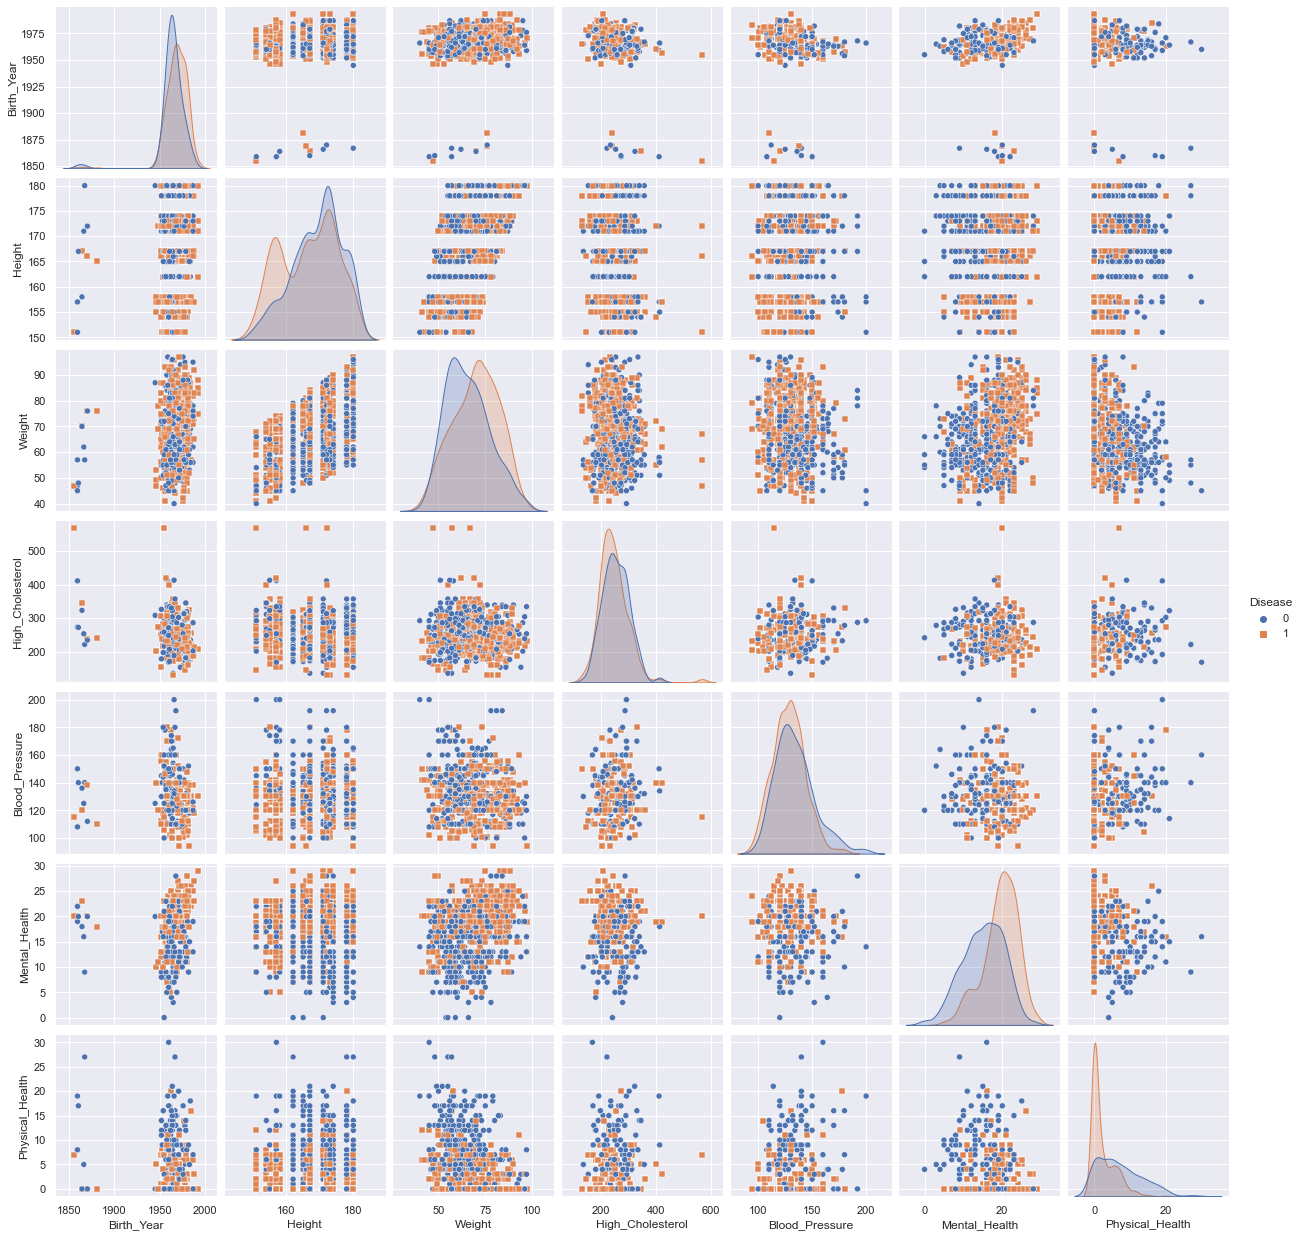

In [11]:
sns.set()

sns.pairplot(df, hue = 'Disease', markers = ['o', 's']);

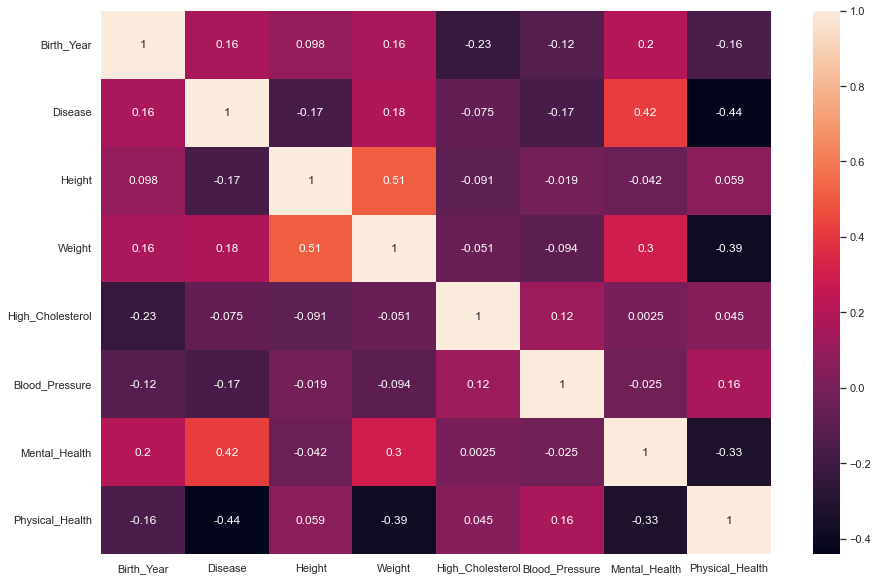

In [12]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),annot=True)
plt.show()

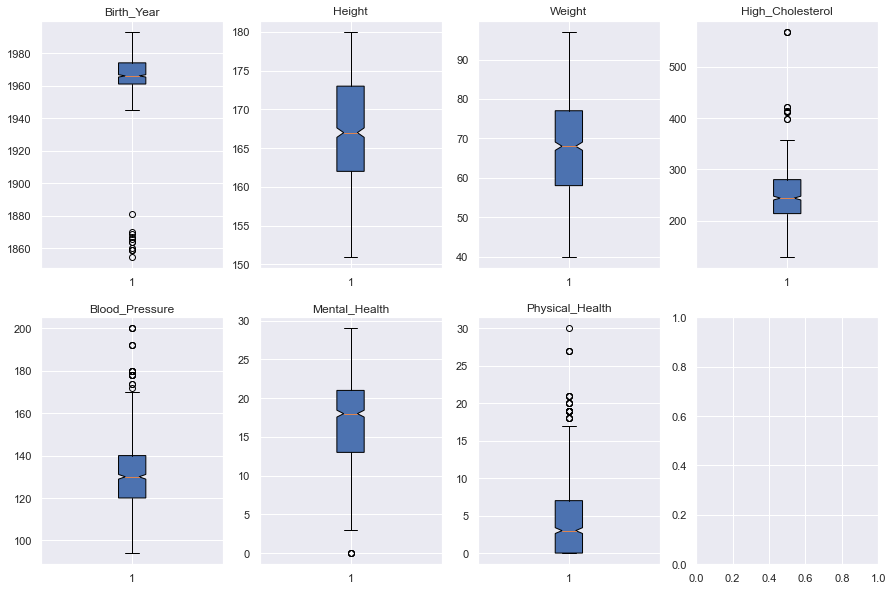

In [13]:
df_numeric_features = list(df.select_dtypes(include = np.number).columns)
df_numeric_features.remove('Disease')

fig, ax = plt.subplots(math.ceil(len(df_numeric_features)/4),4, figsize = (15,10))
for ax, feat in zip(ax.flatten(), df_numeric_features):
    ax.boxplot(df[feat], notch = True, patch_artist = True)
    ax.set_title(feat)

plt.show()

In [14]:
df[df["Birth_Year"]<1945]

,Name,Birth_Year,Region,Education,Disease,Smoking_Habit,Drinking_Habit,Exercise,Fruit_Habit,Water_Habit,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Checkup,Diabetes
PatientID,,,,,,,,,,,,,,,,,,
1591,Mrs. Ashley Pena,1859,Yorkshire and the Humber,Elementary School (1st to 9th grade),0,No,I usually consume alcohol every day,Yes,3 to 4 pieces of fruit in average,More than half a liter but less than one liter,157,47,273,108,22,8,More than 3 years,Neither I nor my immediate family have diabetes.
1481,Mrs. Lisa Cooks,1859,East Midlands,High School Graduate,0,No,I consider myself a social drinker,No,5 to 6 pieces of fruit in average,More than half a liter but less than one liter,157,57,411,150,19,19,Not sure,Neither I nor my immediate family have diabetes.
1288,Mrs. Minnie Hirschfeld,1864,Yorkshire and the Humber,High School Incomplete (10th to 11th grade),1,No,I usually consume alcohol every day,No,Less than 1. I do not consume fruits every day.,Between one liter and two liters,167,70,344,120,23,0,More than 3 years,I have/had pregnancy diabetes or borderline di...
1139,Mr. Gary Baca,1881,East Midlands,University Incomplete (1 to 2 years),1,No,I usually consume alcohol every day,No,Less than 1. I do not consume fruits every day.,Between one liter and two liters,165,76,239,110,18,0,More than 3 years,I do have diabetes
1158,Mrs. Mary Hollingsworth,1855,South West,Elementary School (1st to 9th grade),1,No,I consider myself a social drinker,No,Less than 1. I do not consume fruits every day.,More than half a liter but less than one liter,151,47,568,115,20,7,Not sure,I have/had pregnancy diabetes or borderline di...
1593,Mrs. Nicole Ronin,1859,North East,Elementary School (1st to 9th grade),0,No,I usually consume alcohol every day,Yes,3 to 4 pieces of fruit in average,More than half a liter but less than one liter,151,45,273,108,22,8,More than 3 years,Neither I nor my immediate family have diabetes.
1055,Mr. Douglas Salters,1867,East Midlands,Elementary School (1st to 9th grade),0,No,I usually consume alcohol every day,Yes,Less than 1. I do not consume fruits every day.,Less than half a liter,180,57,221,140,9,27,Not sure,Neither I nor my immediate family have diabetes.
1836,Mrs. Sharyn Furst,1869,West Midlands,High School Graduate,1,No,I consider myself a social drinker,No,Less than 1. I do not consume fruits every day.,More than half a liter but less than one liter,166,76,238,138,20,0,More than 3 years,Neither I nor my immediate family have diabetes.
1803,Mr. Kenneth Ferraro,1870,East of England,High School Graduate,0,No,I usually consume alcohol every day,No,1 to 2 pieces of fruit in average,Between one liter and two liters,172,76,234,112,20,0,More than 3 years,Neither I nor my immediate family have diabetes.


### Takeaways from EDA
- Regarding the numeric features "Physical_Health" does have the highest correlation
- There're outliers in the "Birth_Year" column. Probably not possible?

---
### Baseline
- only numeric features

In [15]:
x, y = df.drop(columns = ['Disease']), df['Disease']

In [16]:
xnumeric = x.select_dtypes(include = np.number)

In [17]:
xtrain, xval, ytrain, yval = train_test_split(xnumeric, y, random_state = 123 ,test_size = 0.3, shuffle = True , stratify = y)

In [18]:
model = LogisticRegression(max_iter = 500)
model.fit(xtrain,ytrain)

ypred = model.predict(xval)

print(classification_report(yval, ypred))

              precision    recall  f1-score   support

           0       0.76      0.72      0.74       117
           1       0.75      0.79      0.77       123

    accuracy                           0.75       240
   macro avg       0.75      0.75      0.75       240
weighted avg       0.75      0.75      0.75       240



---
### Preprocessing
- Impute
- One-Hot-Encoding
- Scale

In [19]:
def preprocessing(dataframe):

    #impute missing values in column "Education" with mode
    dataframe['Education'].fillna(dataframe['Education'].mode()[0], inplace=True)

    #split x in numeric and categorical features
    xnumeric, xcategorical = dataframe.select_dtypes(include = np.number), dataframe.select_dtypes(exclude = np.number)
  
    #One-hot-encoding categorical features
    #drop column "Name" 
    xcategorical.drop(columns = ['Name'], inplace = True)
    x_cat_encoded = pd.concat([pd.get_dummies(xcategorical[col], prefix=col) for col in xcategorical.columns], axis = 1)

    #Scale numeric features
    scaler = MinMaxScaler()
    #scaler = RobustScaler()
    #scaler = StandardScaler()
    x_num_scaled = pd.DataFrame(scaler.fit_transform(xnumeric), index = xnumeric.index ,columns = xnumeric.columns)

    xpreprocessed = pd.concat([x_num_scaled, x_cat_encoded], axis = 1)

    return xpreprocessed

In [20]:
x, y = df.drop(columns = ['Disease']), df['Disease']

In [21]:
xpreprocessed = preprocessing(x)

In [22]:
xpreprocessed

,Birth_Year,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Region_East Midlands,Region_East of England,Region_LONDON,...,Water_Habit_Less than half a liter,Water_Habit_More than half a liter but less than one liter,Checkup_Less than 3 years but more than 1 year,Checkup_Less than three months,Checkup_More than 3 years,Checkup_Not sure,Diabetes_I do have diabetes,"Diabetes_I don't have diabetes, but I have direct family members who have diabetes.",Diabetes_I have/had pregnancy diabetes or borderline diabetes,Diabetes_Neither I nor my immediate family have diabetes.
PatientID,,,,,,,,,,,,,,,,,,,,,
1167,0.797101,0.137931,0.473684,0.520548,0.245283,0.724138,0.066667,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1805,0.826087,0.758621,0.842105,0.228311,0.452830,0.310345,0.000000,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1557,0.862319,0.379310,0.491228,0.219178,0.264151,0.896552,0.000000,0,0,0,...,0,1,0,0,1,0,0,0,0,1
1658,0.746377,1.000000,0.456140,0.417808,0.292453,0.448276,0.266667,0,0,0,...,0,1,0,0,0,1,0,0,1,0
1544,0.818841,1.000000,0.315789,0.335616,0.292453,0.620690,0.066667,0,0,0,...,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1909,0.847826,0.931034,0.368421,0.168950,0.471698,0.413793,0.133333,1,0,0,...,0,0,0,0,0,1,0,0,0,1
1386,0.905797,0.206897,0.368421,0.189498,0.245283,0.793103,0.000000,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1088,0.036232,0.551724,0.140351,0.324201,0.433962,0.689655,0.566667,1,0,0,...,0,1,0,0,1,0,0,0,0,1


In [23]:
xtrain, xval, ytrain, yval = train_test_split(xpreprocessed, y, random_state = 321 ,test_size = 0.2, shuffle = True , stratify = y)

In [24]:
model = RandomForestClassifier()
model.fit(xtrain,ytrain)

ypred = model.predict(xval)

print(classification_report(yval, ypred))

              precision    recall  f1-score   support

           0       0.96      0.90      0.93        78
           1       0.91      0.96      0.93        82

    accuracy                           0.93       160
   macro avg       0.93      0.93      0.93       160
weighted avg       0.93      0.93      0.93       160



---

### Feature Selection
- reduce noise

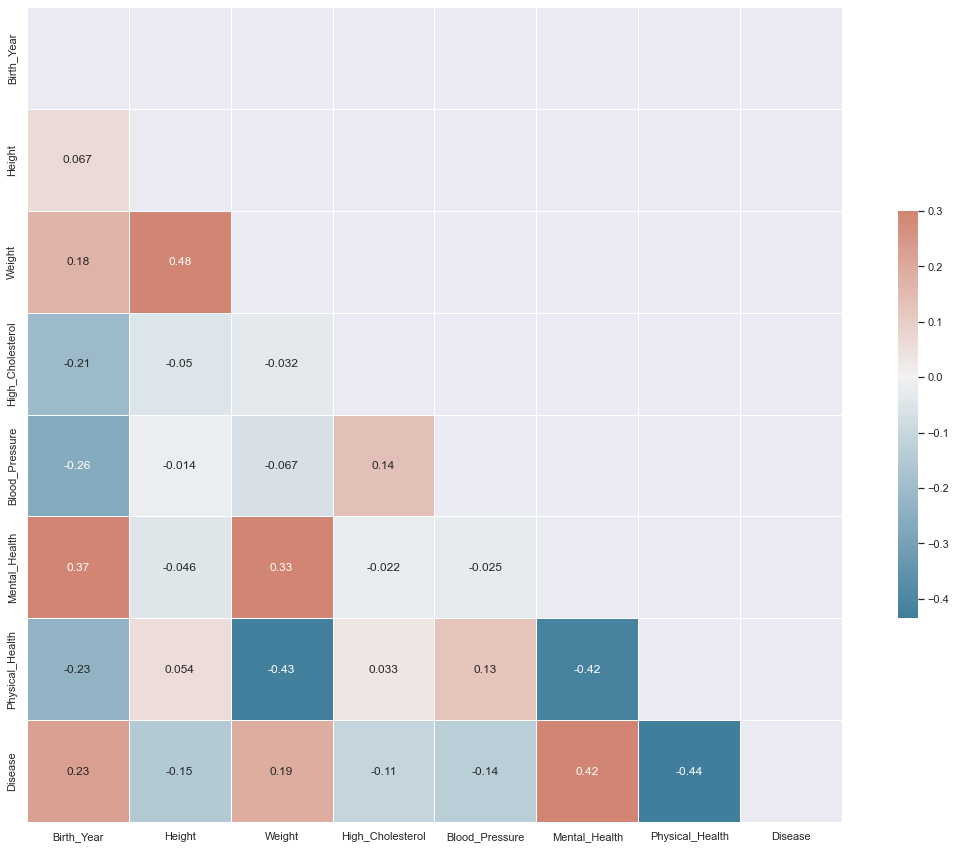

In [25]:
correlation = pd.concat([xnumeric, y], axis = 1).corr(method = 'spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(20, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation, annot = True, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [26]:
model = RandomForestClassifier(random_state = 222)
rfe = RFECV(model, scoring = 'f1')
rfe.fit(xtrain, ytrain)
opt_features = list(rfe.get_feature_names_out(input_features = list(xtrain.columns)))

print(f'Best features: {[i for i in opt_features]}')

Best features: ['Birth_Year', 'Height', 'Weight', 'High_Cholesterol', 'Blood_Pressure', 'Mental_Health', 'Physical_Health', 'Drinking_Habit_I consider myself a social drinker', 'Drinking_Habit_I usually consume alcohol every day', 'Exercise_No', 'Exercise_Yes', 'Fruit_Habit_1 to 2 pieces of fruit in average', 'Fruit_Habit_3 to 4 pieces of fruit in average', 'Fruit_Habit_Less than 1. I do not consume fruits every day.', 'Checkup_More than 3 years', 'Checkup_Not sure', 'Diabetes_I have/had pregnancy diabetes or borderline diabetes', 'Diabetes_Neither I nor my immediate family have diabetes.']


In [27]:
xtrain_rfe = rfe.transform(xtrain)
xval_rfe = rfe.transform(xval)

---
### Model Selection

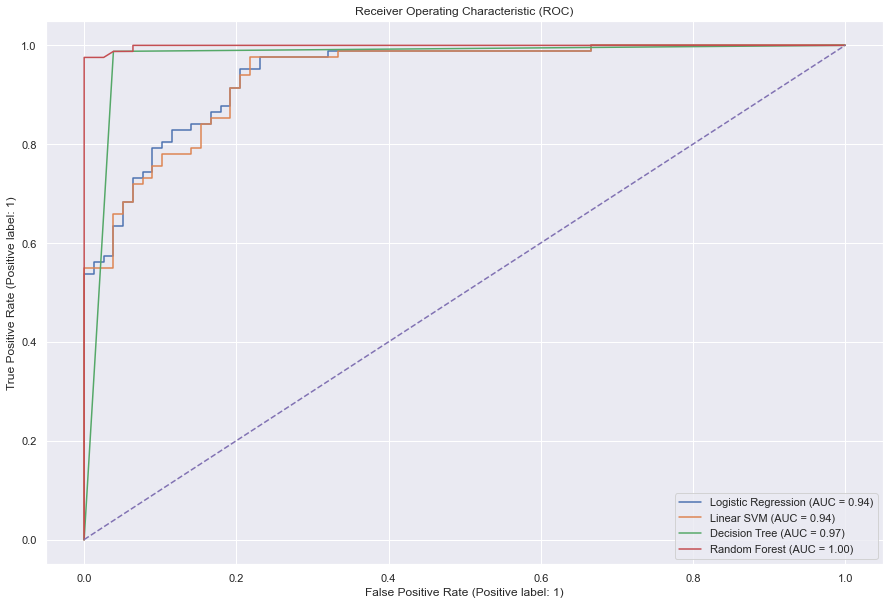

In [28]:
classifiers = {
                'Logistic Regression': LogisticRegression(),
                'Linear SVM': LinearSVC(),
                'Decision Tree': DecisionTreeClassifier(),
                'Random Forest': RandomForestClassifier()
            }

# prepare plots
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

for name, clf in classifiers.items():
    clf.fit(xtrain_rfe, ytrain)
    RocCurveDisplay.from_estimator(clf, xval_rfe, yval, ax=ax, name=name)

ax.set_title("Receiver Operating Characteristic (ROC)")
ax.plot([0,1], [0,1], linestyle='--')

plt.show()

In [29]:
# from mlxtend.plotting import plot_learning_curves

# plot_learning_curves(xtrain_rfe, ytrain, xval_rfe, yval, RandomForestClassifier(), train_marker = '', test_marker = '')
# plt.show()

---
### Hyperparamter tuning

In [30]:
from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier(random_state=333)

parameters = {"n_estimators" : [25,26,40,50,100,150,200], "min_samples_split" : [2,3,5,8,10], "min_samples_leaf" : [1,2,3,5,8,10]}

gridsearch_RFC = GridSearchCV(estimator=model, param_grid=parameters,verbose=3,n_jobs=-1,error_score="raise",return_train_score=True)
resultGS_RFC = gridsearch_RFC.fit(xtrain_rfe, ytrain)


Fitting 5 folds for each of 210 candidates, totalling 1050 fits


---
### Train model with best classifier and optimized feature selection

In [31]:
resultGS_RFC.best_params_

{'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}

In [32]:
resultGS_RFC.score(xval_rfe,yval)

0.99375

In [33]:
grid_model = resultGS_RFC.best_estimator_

In [34]:
validation_pred = grid_model.predict(xval_rfe)
print(classification_report(yval, validation_pred))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99        78
           1       1.00      0.99      0.99        82

    accuracy                           0.99       160
   macro avg       0.99      0.99      0.99       160
weighted avg       0.99      0.99      0.99       160



In [35]:
model = RandomForestClassifier(random_state = 333)
model.fit(xtrain_rfe, ytrain)

RandomForestClassifier(random_state=333)

In [36]:
grid_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 333,
 'verbose': 0,
 'warm_start': False}

In [37]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 333,
 'verbose': 0,
 'warm_start': False}

In [38]:
validation_pred = model.predict(xval_rfe)

print(classification_report(yval, validation_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        78
           1       0.99      0.99      0.99        82

    accuracy                           0.99       160
   macro avg       0.99      0.99      0.99       160
weighted avg       0.99      0.99      0.99       160



---
### Prepare test set

In [39]:
xtest = df_test

xtest_preprocessed = preprocessing(xtest)

#due to one-hot-encoder there's the possibility that we have different columns in the train-test sets
train_not_test = [col for col in list(xpreprocessed.columns) if col not in list(xtest_preprocessed.columns)]

for col in train_not_test:
    xtest_preprocessed[col] = 0

xtest_preprocessed = xtest_preprocessed[list(xpreprocessed.columns)]

xtest_rfe = rfe.transform(xtest_preprocessed)

In [40]:
ypred = model.predict(xtest_rfe)

In [41]:
ypred = grid_model.predict(xtest_rfe)

---
### Create CSV-file for submission

In [42]:
df_submission = pd.concat([pd.Series(xtest.index),pd.Series(ypred)], axis = 1)
df_submission.rename(columns = {0:'Disease'}, inplace = True)
df_submission

,PatientID,Disease
0,1343,1
1,1727,1
2,1828,1
3,1155,1
4,1020,1
...,...,...
220,1000,0
221,1256,1
222,1318,0
223,1953,1


In [43]:
#df_submission.to_csv('Group01_Version01.2_grid.csv', index = False)